Using the data in the link below, attempt to model a customer’s propensity to join our loyalty program: https://bit.ly/2Etq2Ux
***
Genesis L. Taylor


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import time
import timeit

from matplotlib import pyplot as plt
from scipy import stats
from sklearn.model_selection  import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import sklearn.metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, log_loss
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#warning ignorer
import warnings
warnings.filterwarnings("ignore")

plt.style.use('dark_background')

In [2]:
#import dataframe

df = pd.read_csv('https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/customers_data.csv')

In [3]:
#check columns and shape
print(df.columns)
print(df.shape)
df.head()

Index(['Unnamed: 0', 'purch_amt', 'gender', 'card_on_file', 'age',
       'days_since_last_purch', 'loyalty'],
      dtype='object')
(120000, 7)


,Unnamed: 0,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
0,0,19.58,male,no,31.0,35.0,False
1,1,65.16,male,yes,23.0,61.0,False
2,2,40.60,female,no,36.0,49.0,False
3,3,38.01,male,yes,47.0,57.0,False
4,4,22.32,female,yes,5.0,39.0,False


In [4]:
#check info: dtypes, nulls, etc
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 7 columns):
Unnamed: 0               120000 non-null int64
purch_amt                120000 non-null float64
gender                   120000 non-null object
card_on_file             120000 non-null object
age                      120000 non-null float64
days_since_last_purch    120000 non-null float64
loyalty                  120000 non-null bool
dtypes: bool(1), float64(3), int64(1), object(2)
memory usage: 5.6+ MB


In [5]:
df.describe()

,Unnamed: 0,purch_amt,age,days_since_last_purch
count,120000.000000,120000.000000,120000.000000,120000.000000
mean,59999.500000,44.036234,25.803008,56.605908
std,34641.160489,20.473148,10.153072,16.422187
min,0.000000,-43.950000,-22.000000,-9.000000
25%,29999.750000,30.210000,19.000000,45.000000
50%,59999.500000,43.970000,26.000000,57.000000
75%,89999.250000,57.830000,33.000000,68.000000
max,119999.000000,142.200000,71.000000,125.000000


In [6]:
#objects
df.describe(include=[np.object]).transpose()

,count,unique,top,freq
gender,120000,2,male,60181
card_on_file,120000,2,yes,60087


In [7]:
#bool
df.describe(include=[np.bool]).transpose()

,count,unique,top,freq
loyalty,120000,2,False,100000


### Data Cleaning

No null values continue to outliers

In [8]:
#unique values
df.nunique().sort_values(ascending=False)

Unnamed: 0               120000
purch_amt                 11007
days_since_last_purch       128
age                          86
loyalty                       2
card_on_file                  2
gender                        2
dtype: int64

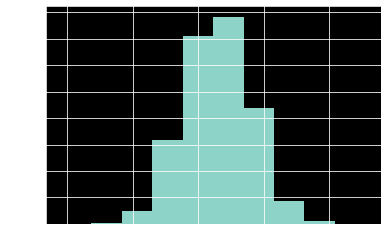

In [9]:
df.age.hist()

We have some outliers and some negative numbers for age. There are no negative ages so they need to be handled. Also, usually with these loyalty programs, people under the age of 13 are not allowed to join, and people under 18 need parental permission. 

With this being said, negative ages and children under 13 will be deleted. 
Under 18 ages will be addressed separately in an age group column.

In [10]:
df = df[df['age']>=13]
print("Age Values")
print("Average Age: ", df['age'].mean())
print("Minimum Age: ", df['age'].min())
print("Maximum Age: ", df['age'].max())
print("Null values: ", pd.isnull(df['age']).sum())

Age Values
Average Age:  27.694735000552466
Minimum Age:  13.0
Maximum Age:  71.0
Null values:  0


In [11]:
#Group the ages into groups
df['age_group'] = pd.cut(df['age'],
                         [13, 18, 25, 35, 45, 55, 71],
                         labels=['Under 18','18-24','25-34','35-44','45-54', '55+'])

In [12]:
df['age_group'].value_counts(ascending=True)

55+           211
45-54        3019
Under 18    14784
35-44       17099
18-24       30376
25-34       41035
Name: age_group, dtype: int64

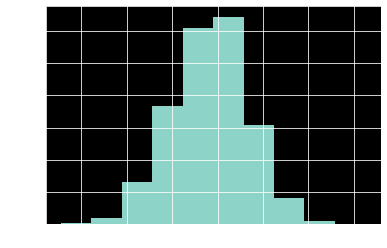

In [13]:
df['days_since_last_purch'].hist()

Days since last purchase also has negative values. Since I am unsure if those negative values indicate returns or anything else, I am going to assume that they are errors. 
 First I am going to get rid of any values less than or equal to zero. From there I will decide if further changes are needed.

In [14]:
df = df[df['days_since_last_purch']>=0]
print("Days Values")
print("Average Days: ", df['days_since_last_purch'].mean())
print("Minimum Days: ", df['days_since_last_purch'].min())
print("Maximum Days: ", df['days_since_last_purch'].max())
print("Null values: ", pd.isnull(df['days_since_last_purch']).sum())

Days Values
Average Days:  56.41451554974353
Minimum Days:  0.0
Maximum Days:  125.0
Null values:  0


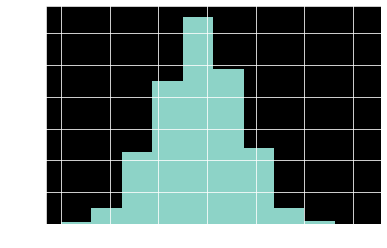

In [15]:
df['days_since_last_purch'].hist()

While there may still be some outliers, they can be understandable depending on the business

Purchase amount also has negative values. As with days since last purchase, I am unsure if those negative values indicate returns or anything else, I am going to assume that they are errors. First I am going to get rid of any values less than or equal to zero. From there I will decide if further changes are needed.

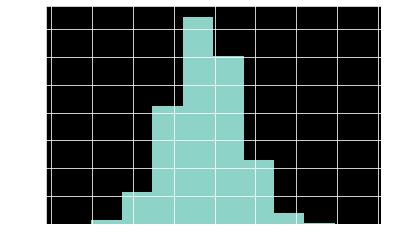

In [16]:
#purch_amt
df['purch_amt'].hist()

In [17]:
df = df[df['purch_amt']>=0]

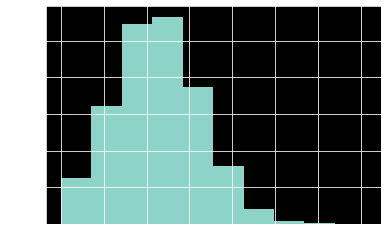

In [18]:
#purch_amt
df['purch_amt'].hist()

In [19]:
df['purch_amt'].describe()

count    106911.000000
mean         44.936517
std          19.621061
min           0.010000
25%          31.050000
50%          44.510000
75%          58.180000
max         142.200000
Name: purch_amt, dtype: float64

There are still some outliers that I am somewhat uncomfortable with, I will handle this using the ideals of quantiles and the interquartile range (IQR).

In [20]:
#(determine the min and max cuttoffs for detecting the outlier)
q75, q25 = np.percentile(df['purch_amt'].dropna(), [75 ,25])
iqr = q75 - q25
 
ecmin = q25 - (iqr*1.5)
ecmax = q75 + (iqr*1.5)

print(ecmax)

98.875


Since I'm only interested at this point in the outliers on the "max" end of the column, I will only be handling ecmax.

In [21]:
df = df[df['purch_amt']<=ecmax]

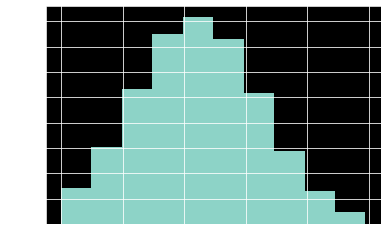

In [22]:
df['purch_amt'].hist()

Better

In [23]:
print(df.shape)
print(df.columns)

(106484, 8)
Index(['Unnamed: 0', 'purch_amt', 'gender', 'card_on_file', 'age',
       'days_since_last_purch', 'loyalty', 'age_group'],
      dtype='object')


Next, I want to create more features, maybe for purchase days and purchase amounts like I did with age.

In [24]:
#create features from days since last purchase

#week
df['weeks_since_last_purch'] = round(df['days_since_last_purch']/7,0)

df['weeks_since_last_purch'].value_counts()

8.0     17500
9.0     16693
7.0     15571
10.0    13290
6.0     12137
11.0     8565
5.0      7940
12.0     4580
4.0      4505
13.0     1957
3.0      1941
2.0       676
14.0      667
15.0      201
1.0       181
16.0       46
0.0        27
17.0        6
18.0        1
Name: weeks_since_last_purch, dtype: int64

In [25]:
#month (using around 30 days as the month increment)

df['months_since_last_purch'] = round(df['days_since_last_purch']/30,0)

df['months_since_last_purch'].value_counts()

2.0    67974
1.0    24801
3.0    12952
0.0      612
4.0      145
Name: months_since_last_purch, dtype: int64

In [26]:
print("Purchase Amount Values")
print("Average Purchase Amount: ", df['purch_amt'].mean())
print("Minimum Purchase Amount: ", df['purch_amt'].min())
print("Maximum Purchase Amount: ", df['purch_amt'].max())
print("Null values: ", pd.isnull(df['purch_amt']).sum())

Purchase Amount Values
Average Purchase Amount:  44.69287207467771
Minimum Purchase Amount:  0.01
Maximum Purchase Amount:  98.81
Null values:  0


In [27]:
#create purchase amount increments
#Group the ages into groups
df['purch_group'] = pd.cut(df['purch_amt'],
                         [0, 25, 50, 75, 100],
                         labels=['Under 25','25-50','51-75','75+'])

In [28]:
df.head(20)

,Unnamed: 0,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty,age_group,weeks_since_last_purch,months_since_last_purch,purch_group
0,0,19.58,male,no,31.0,35.0,False,25-34,5.0,1.0,Under 25
1,1,65.16,male,yes,23.0,61.0,False,18-24,9.0,2.0,51-75
2,2,40.60,female,no,36.0,49.0,False,35-44,7.0,2.0,25-50
3,3,38.01,male,yes,47.0,57.0,False,45-54,8.0,2.0,25-50
6,6,43.96,male,yes,36.0,64.0,False,35-44,9.0,2.0,25-50
7,7,6.09,female,yes,36.0,67.0,False,35-44,10.0,2.0,Under 25
8,8,25.89,female,no,28.0,53.0,False,25-34,8.0,2.0,25-50
9,9,93.63,female,no,40.0,47.0,True,35-44,7.0,2.0,75+
11,11,28.05,male,yes,14.0,46.0,False,Under 18,7.0,2.0,25-50
12,12,60.62,male,yes,16.0,58.0,False,Under 18,8.0,2.0,51-75


In [29]:
df['purch_group'].value_counts(ascending=True)

75+          6758
Under 25    17377
51-75       34822
25-50       47527
Name: purch_group, dtype: int64

In [30]:
#Set Unnamed: 0' to index
df.set_index('Unnamed: 0', inplace=True)

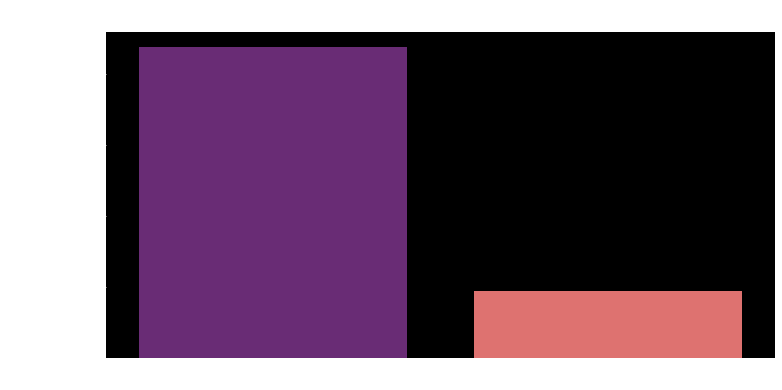

True     18818
False    87666
Name: loyalty, dtype: int64


In [31]:
#Plot loyalty to get an idea of the ratio
plt.figure(figsize=(12,6))
ax=sns.countplot(x="loyalty", palette="magma", data=df)

plt.style.use('dark_background')
plt.title("Loyalty",fontsize=25,fontweight="bold")
plt.xlabel("", fontsize=15, fontweight="bold")
plt.ylabel("\nNumber of Customers\n", fontsize=15, fontweight="bold")
plt.xticks(fontsize=18)
plt.yticks(fontsize=12)
sns.despine(top=True, right=True, left=True, bottom=False)
plt.show()
print(df['loyalty'].value_counts(ascending=True))

In [32]:
df.dtypes

purch_amt                   float64
gender                       object
card_on_file                 object
age                         float64
days_since_last_purch       float64
loyalty                        bool
age_group                  category
weeks_since_last_purch      float64
months_since_last_purch     float64
purch_group                category
dtype: object

In [33]:
df['age_group'] = df['age_group'].astype(str)
df['purch_group'] = df['purch_group'].astype(str)
df.dtypes

purch_amt                  float64
gender                      object
card_on_file                object
age                        float64
days_since_last_purch      float64
loyalty                       bool
age_group                   object
weeks_since_last_purch     float64
months_since_last_purch    float64
purch_group                 object
dtype: object

In [34]:
#separate the data into object vs nonobjects
notif=df.select_dtypes(exclude=['int','float','int64'])
intfldtypes = df.select_dtypes(include=['int','float','int64'])
print(df.shape)
print(notif.shape)
print(intfldtypes.shape)

(106484, 10)
(106484, 5)
(106484, 5)


In [35]:
#label encode objects
obj_le= notif.apply(LabelEncoder().fit_transform)
#re-add with non-objects
df_ml= pd.concat([obj_le,intfldtypes], axis=1, sort=False)
#check shape
print(df_ml.shape)

(106484, 10)


In [36]:
#check correlation
df_ml.corr()['loyalty']

gender                     0.002016
card_on_file               0.000061
loyalty                    1.000000
age_group                 -0.016306
purch_group               -0.005534
purch_amt                  0.211915
age                        0.169726
days_since_last_purch     -0.465956
weeks_since_last_purch    -0.462277
months_since_last_purch   -0.418968
Name: loyalty, dtype: float64

In [37]:
#set X and y
X=df_ml.drop(['loyalty'],axis=1)
y=df_ml['loyalty']

In [38]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=27)

In [39]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

In [40]:
# separate minority and majority classes
not_loyalty = X[X.loyalty==0]
loyalty = X[X.loyalty==1]

In [41]:
# decrease majority
not_loyalty_decreased = resample(not_loyalty,
                          replace=True, # sample with replacement
                          n_samples=len(loyalty), # match number in majority class
                          random_state=27) # reproducible results

In [42]:
# combine majority and loyalty_increased minority
newdf = pd.concat([loyalty, not_loyalty_decreased])

In [43]:
#recheck values of lyalty
newdf.loyalty.value_counts()

1    14146
0    14146
Name: loyalty, dtype: int64

In [44]:
#set new X and y training data
X_train = newdf.drop('loyalty', axis=1)
y_train = newdf['loyalty']

scaler = StandardScaler()

#fit training set
scaler.fit(X_train)

# Apply transform to both the training set and the test set
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [45]:
#confusion matrix plot function
def cm_plot(var):
    plt.figure(figsize=(15,5))
    plt.clf()
    plt.imshow(var, interpolation='nearest', cmap='viridis')
    classNames = ['No Loyalty','Loyalty']
    plt.title('Confusion Matrix')
    plt.ylabel('Actual\n')
    plt.xlabel('Predicted\n')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+"="+str(var[i][j]),horizontalalignment='center')
    plt.show()





SVC Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 78.6334%
Cross validation scores: 0.7891277814205292
Log Loss: 0.4959796797258027


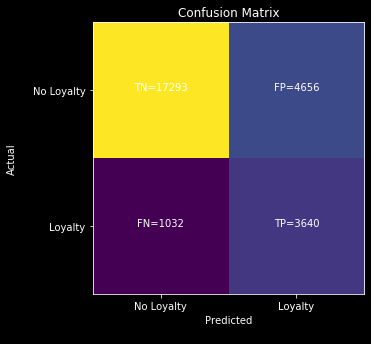





RandomForestClassifier Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 75.2789%
Cross validation scores: 0.7815989264826823
Log Loss: 0.6120240784338765


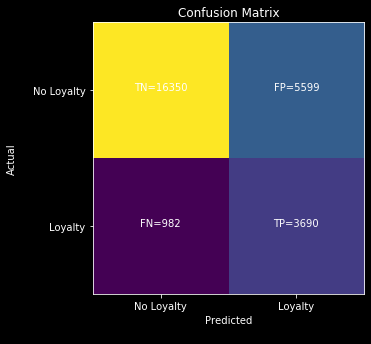





AdaBoostClassifier Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 77.5741%
Cross validation scores: 0.7901878970111751
Log Loss: 0.6814076969143326


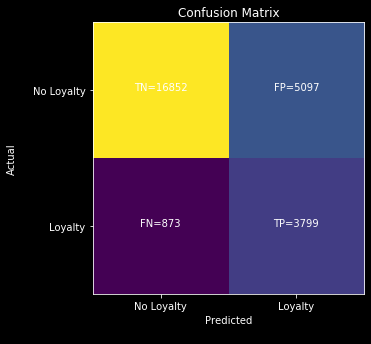





GradientBoostingClassifier Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 77.9497%
Cross validation scores: 0.7928033924658308
Log Loss: 0.45222127833781683


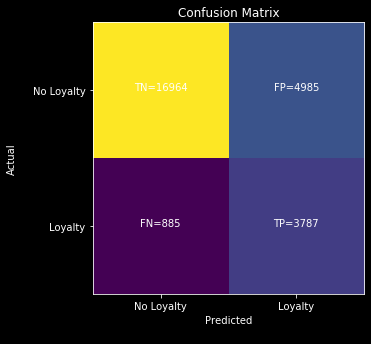





XGBClassifier Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 77.9310%
Cross validation scores: 0.7935103335710866
Log Loss: 0.451735243909281


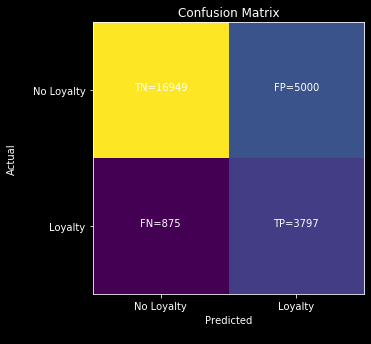





ExtraTreesClassifier Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 73.5848%
Cross validation scores: 0.7698995485087057
Log Loss: 0.9271580230834471


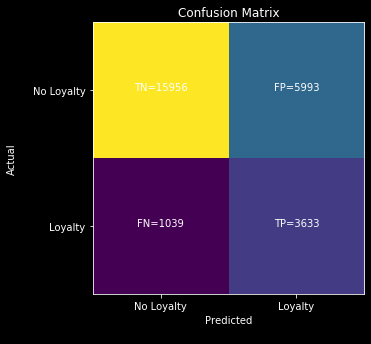





LGBMClassifier Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 77.8483%
Cross validation scores: 0.791919897847059
Log Loss: 0.4552361993730162


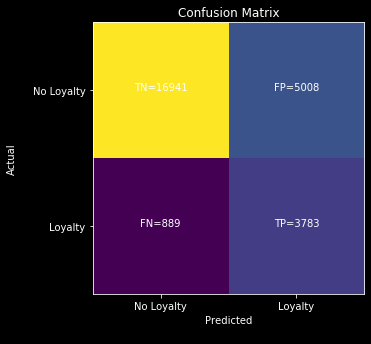

****************************************


In [46]:
#Try modeling using  different classification models
classifiers = [
    SVC(probability=True, random_state=42),
    #DecisionTreeClassifier(), worst performer so I commented out for plotting
    RandomForestClassifier(random_state=42, n_estimators=100),
    AdaBoostClassifier(random_state=42, n_estimators=100),
    GradientBoostingClassifier(random_state=42, n_estimators=100),
    XGBClassifier(random_state=42, n_estimators=100),
    ExtraTreesClassifier(random_state=42, n_estimators=100),
    LGBMClassifier(random_state=42, n_estimators=100)]

#putting results in df
res_cols=["Classifier", "Accuracy", "Log Loss", "Cross Val", "Recall", "Roc Auc","F1", 
          "False Positive Rate", "Error Rate"]
results = pd.DataFrame(columns=res_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("\n"*3)
    print(name,"Results:")
       
    print('~'*40)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy: {:.4%}".format(acc))
    
    cv= np.mean(cross_val_score(clf, X_train, y_train, cv=3))
    print("Cross validation scores:",cv)
    
    
    train_predictions = clf.predict_proba(X_test)
    logloss = log_loss(y_test, train_predictions)
    print("Log Loss: {}".format(logloss))
    
    cm = confusion_matrix(y_test, y_pred)
    
    cm_plot(cm)
    
    #FPR and Error Rate setup
    tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
    
    fpr = fp/(tn+fp)
    ers = 1-acc
    rec= recall_score(y_test, y_pred)
    roc=roc_auc_score(y_test, y_pred)
    f1s=f1_score(y_test, y_pred)
    results_final = pd.DataFrame([[name, round(acc*100,3), round(logloss,3), 
                                   round(cv*100,3), round(rec*100,3), round(roc*100,3),
                                   round(f1s*100,3),round(fpr*100,3),round(ers*100,3)]],
                                 columns=res_cols)
    results = results.append(results_final)
    
print("*"*40)

In [47]:
print("Shape",results.shape)
results.head(10)

Shape (7, 9)


,Classifier,Accuracy,Log Loss,Cross Val,Recall,Roc Auc,F1,False Positive Rate,Error Rate
0,SVC,78.633,0.496,78.913,77.911,78.349,56.138,21.213,21.367
0,RandomForestClassifier,75.279,0.612,78.160,78.981,76.736,52.862,25.509,24.721
0,AdaBoostClassifier,77.574,0.681,79.019,81.314,79.046,55.999,23.222,22.426
0,GradientBoostingClassifier,77.950,0.452,79.280,81.057,79.173,56.337,22.712,22.050
0,XGBClassifier,77.931,0.452,79.351,81.271,79.246,56.381,22.780,22.069
0,ExtraTreesClassifier,73.585,0.927,76.990,77.761,75.228,50.818,27.304,26.415
0,LGBMClassifier,77.848,0.455,79.192,80.972,79.078,56.198,22.817,22.152


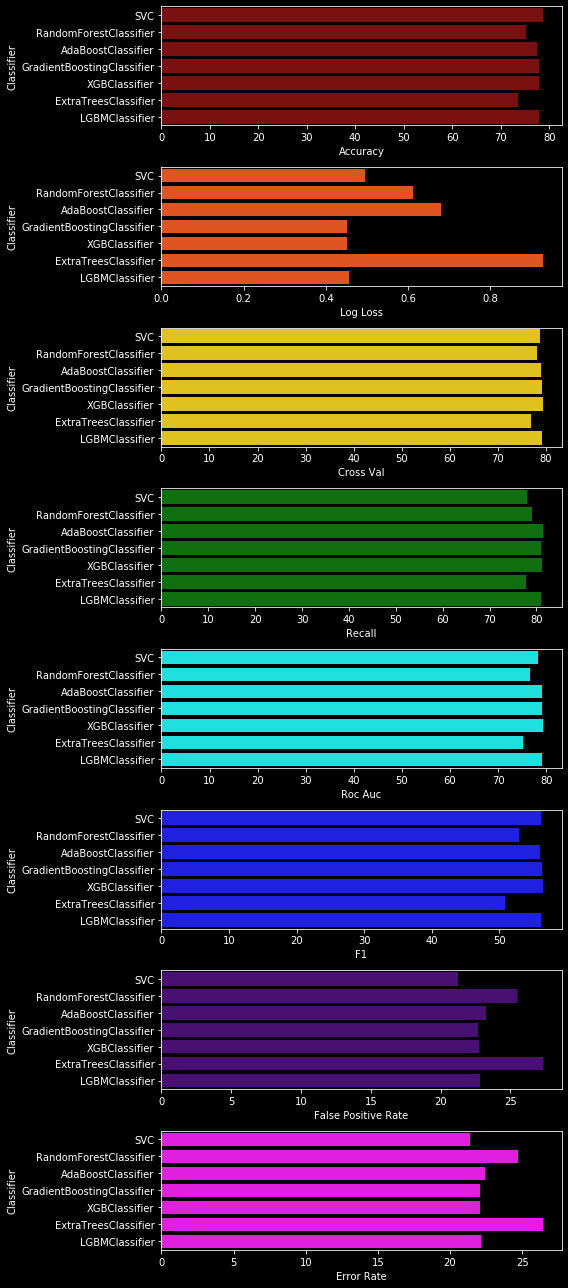

In [48]:
#Visualize accuracy and loss for all model
fig, ax =plt.subplots(nrows=8, ncols=1,figsize = (8,18))
sns.barplot(x='Accuracy', y='Classifier', data=results, color="darkred", ax=ax[0])
sns.barplot(x='Log Loss', y='Classifier', data=results, color="orangered", ax=ax[1])
sns.barplot(x='Cross Val', y='Classifier', data=results, color="gold", ax=ax[2])
sns.barplot(x='Recall', y='Classifier', data=results, color="green", ax=ax[3])
sns.barplot(x='Roc Auc', y='Classifier', data=results, color="cyan", ax=ax[4])
sns.barplot(x='F1', y='Classifier', data=results, color="blue", ax=ax[5])
sns.barplot(x='False Positive Rate', y='Classifier', data=results, color="indigo", ax=ax[6])
sns.barplot(x='Error Rate', y='Classifier', data=results, color="magenta", ax=ax[7])
plt.tight_layout()
plt.show()

Although the results were close, SVC gave the best results of the 7. With that being known, I decided to performing tuning on the algorithm to find the best result.

In [49]:
# svc_params =  {'C':[1,10,100],
#                'gamma':['scale',1,0.1,0.001], 
#                'kernel':['linear','poly','rbf', 'sigmoid'],
#                'probability':[True],
#                'class_weight':['balanced'],
#                'random_state':[42]}

# grid_svc = GridSearchCV(SVC(), svc_params)
# grid_svc.fit(X_train, y_train)

# ## SVC best parameters
# svc_best = grid_svc.best_estimator_

# print("Support Vector Classifier:\n",grid_svc.best_params_)

Support Vector Results
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy Score: 78.68%
F1 Score: 71.12%
Precision Score: 69.23%
Recall Score: 78.56%
Cross Validation Score: 78.99%
Log Loss Score: 0.4552361993730162
False Positive Rate: 21.26%
Error Rate: 22.15%


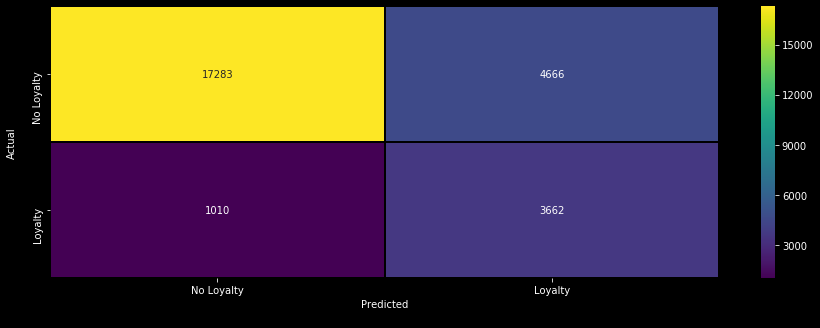

In [72]:
svc = SVC(C=2,class_weight='balanced', probability=True, random_state = 42)
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)

print('Support Vector Results')
print('~'*30)
print("Accuracy Score: {:0.2f}%".format(accuracy_score(y_test,pred_svc )*100))
print("F1 Score: {:0.2f}%".format(f1_score(y_test, pred_svc, average="macro")*100))
print("Precision Score: {:0.2f}%".format(precision_score(y_test,pred_svc, average="macro")*100))
print("Recall Score: {:0.2f}%".format(recall_score(y_test, pred_svc, average="macro")*100))
print("Cross Validation Score: {:0.2f}%".format(np.mean(cross_val_score(svc, 
                                                                        X_train, y_train, cv=3)*100)))


train_predictions = clf.predict_proba(X_test)
logloss = log_loss(y_test, train_predictions)
print("Log Loss Score:",logloss)

      
#FPR and Error Rate setup
tn, fp, fn, tp = confusion_matrix(y_test,pred_svc).ravel()
fpr = fp/(tn+fp)
ers = 1-acc
print("False Positive Rate: {:0.2f}%".format(fpr*100))
print("Error Rate: {:0.2f}%".format(ers*100))

svc_cm = confusion_matrix(y_test,pred_svc)
svc_cm_df = pd.DataFrame(svc_cm, 
                         index = ['No Loyalty','Loyalty'], 
                         columns = ['No Loyalty','Loyalty'])
plt.figure(figsize=(15,5))

sns.heatmap(svc_cm_df, annot=True, fmt="d", cmap='viridis', linecolor='black', linewidths=1)
plt.ylabel('Actual\n')
plt.xlabel('Predicted\n')
plt.show()